# Calculation of the measures with Parselmouth

This program computes the measures that use praat's code through Parselmouth python library, plus the MFCC. 
This contemplates the following feature: 
- Mean Pitch and Standart deviation;
- HNR;
- Jitter, in the 5 different ways;
- Shimmer, in the 6 different ways; 
- CPP;

Besides this, it also performs a PCA to both jitter and shimmer.


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics
import librosa
import seaborn as sns

from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
#Function to run PCA for jitter and shimmer
def runPCA(df):
    #Jitter and Shimmer measurements
    features = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    # Separating out the features
    x = df.loc[:, features].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #PCA
    pca = PCA(n_components=2)
    pComp = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = pComp, columns = ['Jitter', 'Shimmer'])
    principalDf
    return principalDf

In [4]:
# Function to measure all the features
def measureFeat(voiceID, f0min, f0max, unit, sr):
    
    #Uses parselmouth
    sound_o = parselmouth.Sound(voiceID)  # read the sound
    sound = call(sound_o, "Resample", 8000, 40.0)
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max)     # create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit)    # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit)    # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 5.0)     # get the degree of periodicity (HNR) object with the auto-correlation method
    hnr = call(harmonicity, "Get mean", 0, 0)                   # get the mean of HNR
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)                        # get the time points near high amplitude
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)                           # get the local jitter for the time points of the point process object, in %
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)         # get the absolute jitter, in seconds
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)                     # get jitter through Relative Average Perturbation, given in %
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)                   # get the jitter with a five-point Period Perturbation Quotient, in %
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)                 # get jitter with the Difference of Differences of Periods, in %
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)             # get absolute shimmer, in % 
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)            # get the local shimmer , in dB
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)              # get shimmer with three-point Period Perturbation Quotient, in %
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)            # get shimmer with five-point Period Perturbation Quotient, in %
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)              # get shimmer with eleven-point Period Perturbation Quotient, in %
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)                 # get shimmer with the Difference of Differences of amplitude, in %
    cepstrum = call(sound, "To PowerCepstrogram", 60.0, 0.002, 5000.0, 330.0)                 # get the power cepstogram of the signal 
    cpp = call(cepstrum, "Get CPPS",1, 0.02, 0.0005, 60.0, 330.0, 0.05, 'parabolic', 0.001, 0, 'Straight', 'Robust')   # get the CPPsmooth using the power cepstogram 
    
    #Using librosa fro MFCC.
    signal, sr = librosa.load(voiceID, sr = sr)   
    mfcc_feat = librosa.feature.mfcc(y=signal, n_mfcc=14, sr=sr, hop_length = 80, win_length= 260)                # computes the MFCC  
    mfcc_process = np.mean(mfcc_feat.T, axis=0)                                                                  # get the mean of each coeffient vector, obtaining a 14 coefficients vector 

    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer, cpp, mfcc_process

In [5]:
#SVD
#dir = "Database/SVD" ; n = 'svd'

#directory of D2s 
dir = "Database/waves2s"; n = '2s'

#directory of D1s 
#dir = "Database/waves1s"; n = '1s'

# create lists to put the results
file_list = []
duration_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
cpp_list = []
mfcc_lib = pd.DataFrame(columns=['features'])
df=[]

    
# Go through all the wave files in the folder and computes all features
for wave_file in glob.glob(dir+'/*.wav'):
    
    #To select from SVD the duration 
    duration_list.append(librosa.get_duration(path=wave_file))
            
    (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter,
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, 
     ddaShimmer, cpp, mfcc) = measureFeat(wave_file, 75, 500, "Hertz", 8000)

    #appends the data into its respective list
    file_list.append(os.path.basename(wave_file)) 
    mean_F0_list.append(meanF0)
    sd_F0_list.append(stdevF0) 
    hnr_list.append(hnr)
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)
    cpp_list.append(cpp)
    mfcc_lib = mfcc_lib.append({'features': mfcc}, ignore_index = True)

    #Data Frame with all features
df = pd.DataFrame(np.column_stack([file_list, duration_list, mean_F0_list, sd_F0_list, hnr_list, 
                                localJitter_list, localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list,
                                localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list, cpp_list]),
                                columns=['voiceID', 'duration[s]', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer', 'CPPs'])  

#For NaN values due to the lack of peaks
df_pca=df.replace('nan',0)

#Performs PCA for jitter a0nd shimmer
pcaData = runPCA(df_pca)
cols = ['voiceID', 'duration[s]', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs'] 
df_pca = pd.concat([df[cols], pcaData], axis = 1)


#Divide the MFCC vector in columns
col = ['M1', 'M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12','M13', 'M14']
mfcc_div = pd.DataFrame(0.0,index = range(len(df)), columns=col)
for i in range(len(df)):
    a = mfcc_lib.iloc[i,0]
    l = 0
    for x in col:         
        mfcc_div[x][i]= a[l]
        if l<13:
            l =l+1

df_pca[col] = mfcc_div
    
#df_pca.drop(df_pca.loc[df_pca['meanF0Hz']==0].index, inplace=True)
df_pca.head()

,voiceID,duration[s],meanF0Hz,stdevF0Hz,HNR,CPPs,Jitter,Shimmer,M1,M2,...,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14
0,voice001.wav,2.0,128.3768595123381,0.6601403254847062,25.304728349740568,20.395498720414835,-2.380305,0.522537,-126.985306,109.895248,...,-18.222916,-9.375790,-29.963949,11.304980,14.582930,-30.320269,-28.443420,-12.783490,-4.971278,5.192384
1,voice002.wav,2.0,128.49495716151878,0.5427649113721428,26.067053881749576,20.044408614711298,-2.457376,0.571143,-124.572098,115.678383,...,-20.973980,-6.441000,-30.672676,8.869726,16.325291,-34.935776,-24.555573,-12.511703,-1.245954,2.473820
2,voice003.wav,2.0,128.40617900808334,0.5365610711315758,27.401512272735232,20.575478543371837,-2.573412,0.662827,-107.799126,106.594971,...,-26.438219,-4.247687,-31.243427,10.295753,14.286288,-36.599899,-20.525337,-11.950883,0.830372,-0.517821
3,voice004.wav,2.0,183.49619278968405,1.1612341232812977,22.512837556776333,18.642654959684755,-2.052522,0.546600,-154.539856,81.862404,...,20.358231,-23.401800,-13.765859,0.058484,-24.701546,-16.549885,-28.047493,-6.504747,-22.374962,-3.391365
4,voice005.wav,2.0,182.8688208337542,0.9540160008986274,22.86004294218231,18.419412505235474,-2.029009,0.514358,-160.415680,84.697159,...,22.733835,-28.310465,-10.739703,-4.311200,-21.167278,-17.594528,-31.991764,-5.311715,-21.560118,-2.296989


In [16]:
# Save the dataframe
save = 'dados_' + n + '_feat.csv'
df_pca.to_csv(os.path.join("Dados", save), index=False)

##### Only for D1s and D2s
Gathering the data from matlab file, that computes Pearson's r with different filters, and woth all the info given of the patiens, from the data base

In [6]:
file = 'dados_' + n + '_mat.txt'
df_mat = pd.read_csv(os.path.join('Dados',file))  #file from matlab with r and patient's info 

df2 = pd.concat([df_pca, df_mat], axis=1)
print("Columns of the new dataframe: ", format(list(df2.columns)))
df2.head(5) 

Columns of the new dataframe:  ['voiceID', 'duration[s]', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs', 'Jitter', 'Shimmer', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'ID', 'Age', 'Gender', 'CPPVoiceDet', 'Pitch', 'r', 'Butter_high', 'Butter_band', 'Ellip_high', 'Ellip_band', 'VHI', 'RSI', 'DiagnosticsSVM', 'Diagnostics']


,voiceID,duration[s],meanF0Hz,stdevF0Hz,HNR,CPPs,Jitter,Shimmer,M1,M2,...,Pitch,r,Butter_high,Butter_band,Ellip_high,Ellip_band,VHI,RSI,DiagnosticsSVM,Diagnostics
0,voice001.wav,2.0,128.3768595123381,0.6601403254847062,25.304728349740568,20.395498720414835,-2.380305,0.522537,-126.985306,109.895248,...,128.380235,0.948733,0.914250,0.893563,0.917581,0.941721,17,12,healthy,1
1,voice002.wav,2.0,128.49495716151878,0.5427649113721428,26.067053881749576,20.044408614711298,-2.457376,0.571143,-124.572098,115.678383,...,128.490635,0.964995,0.939707,0.925568,0.946247,0.963160,17,12,healthy,1
2,voice003.wav,2.0,128.40617900808334,0.5365610711315758,27.401512272735232,20.575478543371837,-2.573412,0.662827,-107.799126,106.594971,...,128.412828,0.962231,0.931082,0.919537,0.932786,0.957145,17,12,healthy,1
3,voice004.wav,2.0,183.49619278968405,1.1612341232812977,22.512837556776333,18.642654959684755,-2.052522,0.546600,-154.539856,81.862404,...,183.502863,0.948921,0.874602,0.862308,0.902296,0.916558,45,10,healthy,1
4,voice005.wav,2.0,182.8688208337542,0.9540160008986274,22.86004294218231,18.419412505235474,-2.029009,0.514358,-160.415680,84.697159,...,182.872153,0.974492,0.928507,0.922365,0.949329,0.956303,45,10,healthy,1


In [7]:
# Create dummy columns for gender 
df_dummie = pd.get_dummies(df2, columns=['Gender'])
new_col = ['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs','Jitter', 'Shimmer', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
                 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'ID', 'Age', 'Gender_f', 'Gender_m',
                  'r', 'Butter_high', 'Butter_band', 'Ellip_high', 'Ellip_band', 'VHI', 'RSI', 'DiagnosticsSVM',
                 'Diagnostics']
df_all = df_dummie[new_col]
df_all

,voiceID,meanF0Hz,stdevF0Hz,HNR,CPPs,Jitter,Shimmer,M1,M2,M3,...,Gender_m,r,Butter_high,Butter_band,Ellip_high,Ellip_band,VHI,RSI,DiagnosticsSVM,Diagnostics
0,voice001.wav,128.3768595123381,0.6601403254847062,25.304728349740568,20.395498720414835,-2.380305,0.522537,-126.985306,109.895248,-57.908405,...,1,0.948733,0.914250,0.893563,0.917581,0.941721,17,12,healthy,1
1,voice002.wav,128.49495716151878,0.5427649113721428,26.067053881749576,20.044408614711298,-2.457376,0.571143,-124.572098,115.678383,-51.601883,...,1,0.964995,0.939707,0.925568,0.946247,0.963160,17,12,healthy,1
2,voice003.wav,128.40617900808334,0.5365610711315758,27.401512272735232,20.575478543371837,-2.573412,0.662827,-107.799126,106.594971,-47.281765,...,1,0.962231,0.931082,0.919537,0.932786,0.957145,17,12,healthy,1
3,voice004.wav,183.49619278968405,1.1612341232812977,22.512837556776333,18.642654959684755,-2.052522,0.546600,-154.539856,81.862404,-44.399982,...,0,0.948921,0.874602,0.862308,0.902296,0.916558,45,10,healthy,1
4,voice005.wav,182.8688208337542,0.9540160008986274,22.86004294218231,18.419412505235474,-2.029009,0.514358,-160.415680,84.697159,-40.372349,...,0,0.974492,0.928507,0.922365,0.949329,0.956303,45,10,healthy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,voice310.wav,107.04730247596493,0.8857616751706884,17.322162015399233,22.79569253456826,-1.946221,0.497065,-77.432907,38.973644,-25.669905,...,1,0.833342,0.667926,0.836523,0.554303,0.822051,41,3,pathological,0
310,voice311.wav,138.75281140482994,50.29757182302288,5.832049173295385,11.09304367732891,6.777514,-2.289640,-102.677689,48.121082,-57.508076,...,0,-0.087028,-0.049664,-0.028177,-0.112557,-0.132279,65,23,pathological,0
311,voice312.wav,218.31748829837085,1.0408002126177702,16.747750073446266,13.167462431910865,0.544361,-0.660565,-134.398941,59.155537,-49.953159,...,0,0.962045,0.846962,0.817203,0.900460,0.929336,78,14,pathological,0
312,voice313.wav,221.2912158726678,1.3006819311191642,17.955218440811958,16.263097289639802,-0.645196,-0.576146,-162.840332,56.977165,-53.612785,...,0,0.971729,0.937168,0.907075,0.907466,0.945580,62,19,pathological,0


In [8]:
# Check for invalid rows
invalid_rows = [index for index, row in df_all.iterrows() if row.isnull().values.any()]
print(invalid_rows)
df_all = df_all.drop(index= invalid_rows) #deletes those rows
df_all

[]


,voiceID,meanF0Hz,stdevF0Hz,HNR,CPPs,Jitter,Shimmer,M1,M2,M3,...,Gender_m,r,Butter_high,Butter_band,Ellip_high,Ellip_band,VHI,RSI,DiagnosticsSVM,Diagnostics
0,voice001.wav,128.3768595123381,0.6601403254847062,25.304728349740568,20.395498720414835,-2.380305,0.522537,-126.985306,109.895248,-57.908405,...,1,0.948733,0.914250,0.893563,0.917581,0.941721,17,12,healthy,1
1,voice002.wav,128.49495716151878,0.5427649113721428,26.067053881749576,20.044408614711298,-2.457376,0.571143,-124.572098,115.678383,-51.601883,...,1,0.964995,0.939707,0.925568,0.946247,0.963160,17,12,healthy,1
2,voice003.wav,128.40617900808334,0.5365610711315758,27.401512272735232,20.575478543371837,-2.573412,0.662827,-107.799126,106.594971,-47.281765,...,1,0.962231,0.931082,0.919537,0.932786,0.957145,17,12,healthy,1
3,voice004.wav,183.49619278968405,1.1612341232812977,22.512837556776333,18.642654959684755,-2.052522,0.546600,-154.539856,81.862404,-44.399982,...,0,0.948921,0.874602,0.862308,0.902296,0.916558,45,10,healthy,1
4,voice005.wav,182.8688208337542,0.9540160008986274,22.86004294218231,18.419412505235474,-2.029009,0.514358,-160.415680,84.697159,-40.372349,...,0,0.974492,0.928507,0.922365,0.949329,0.956303,45,10,healthy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,voice310.wav,107.04730247596493,0.8857616751706884,17.322162015399233,22.79569253456826,-1.946221,0.497065,-77.432907,38.973644,-25.669905,...,1,0.833342,0.667926,0.836523,0.554303,0.822051,41,3,pathological,0
310,voice311.wav,138.75281140482994,50.29757182302288,5.832049173295385,11.09304367732891,6.777514,-2.289640,-102.677689,48.121082,-57.508076,...,0,-0.087028,-0.049664,-0.028177,-0.112557,-0.132279,65,23,pathological,0
311,voice312.wav,218.31748829837085,1.0408002126177702,16.747750073446266,13.167462431910865,0.544361,-0.660565,-134.398941,59.155537,-49.953159,...,0,0.962045,0.846962,0.817203,0.900460,0.929336,78,14,pathological,0
312,voice313.wav,221.2912158726678,1.3006819311191642,17.955218440811958,16.263097289639802,-0.645196,-0.576146,-162.840332,56.977165,-53.612785,...,0,0.971729,0.937168,0.907075,0.907466,0.945580,62,19,pathological,0


#### Selection of the the pearson's r, calculated aside in matlab, that best correlates with the output.


In [21]:
# import seaborn as sn
# import matplotlib.pyplot as plt

# # Do the correlation matrix between the r and the output
# r = df_all[['r','Butter_high','Butter_band', 'Ellip_high', 'Ellip_band', 'Diagnostics']] 
# corr_matrix = r.corr()
# sn.heatmap(corr_matrix, annot=True)
# plt.show()

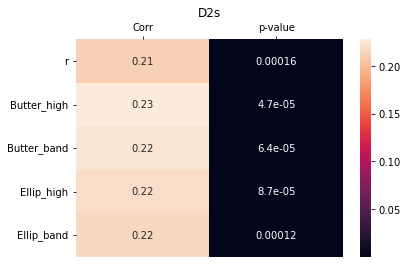

In [9]:
#df_r = pd.DataFrame(columns=['Method','Corr', 'p-value']) #, index = ['r','Butter_high','Butter_band', 'Ellip_high', 'Ellip_band'])
r = df_all[['r','Butter_high','Butter_band', 'Ellip_high', 'Ellip_band']] 
y = np.array(df_all['Diagnostics'])
df_r = pd.DataFrame(np.zeros((len(r.columns), 2)), index = r.columns, columns=['Corr', 'p-value'])

for column in r:
    x = np.array(df_all[column])
    res, p_val = stats.pointbiserialr(y, x)
    df_r.loc[column, 'Corr'] = res
    df_r.loc[column, 'p-value'] = p_val #append({'Corr': res, 'p-value': p_val}, ignore_index=True)
    
hm = sns.heatmap(data=df_r, annot=True)
hm.set_title('D2s')
hm.xaxis.tick_top()

In [56]:
# Assim só deixmaos o que tem maios corr com o diagnostic que é o butter high
r_max = df_all[df_r.loc[df_r['Corr'].abs().idxmax()].name]
print('The method with maximum value: ', r_max.name)
df_all= df_all.drop(columns = ['r','Butter_band','Butter_high', 'Ellip_high', 'Ellip_band'])
df_all['r'] = r_max
#df_all = df_all.drop(df_all.index[72])
df_all.columns

The method with maximum value:  Butter_high


Index(['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs', 'Jitter', 'Shimmer',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11',
       'M12', 'M13', 'M14', 'ID', 'Age', 'Gender_f', 'Gender_m', 'VHI', 'RSI',
       'DiagnosticsSVM', 'Diagnostics', 'r'],
      dtype='object')

In [57]:
# Save the dataframe
save = 'dados_' + n + '_modelos.csv'
df_all.to_csv(os.path.join("Dados", save), index=False)

### For SVD
run this part to get the r

In [6]:
df_mat = pd.read_csv('Dados\dados_svd_mat.txt')
df_mat

,voiceID,Diagnostics,Age,Gender_f,Gender_m,duration_s_,meanF0Hz,stdevF0Hz,HNR,CPPs,...,M10,M11,M12,M13,M14,r,Butter_high,Butter_band,Ellip_high,Ellip_band
0,1-a_n.wav,1,19,1,0,1.94836,274.456637,2.331778,22.137981,16.260278,...,-17.333477,-35.260818,-4.077249,-10.640229,-11.480056,0.977297,0.227641,0.702570,0.968130,0.964468
1,2-a_n.wav,1,22,1,0,0.76166,224.860181,1.259968,22.213716,17.716272,...,-24.179432,-23.717274,-0.718097,-34.878387,-13.535369,0.980314,0.565009,0.831358,0.980425,0.979145
2,3-a_n.wav,1,24,1,0,1.13270,252.919659,1.315275,20.758912,14.118611,...,10.912569,-17.886742,-13.646948,-17.928291,1.948002,-0.183031,-0.036009,-0.031783,-0.183217,-0.184817
3,4-a_n.wav,1,22,0,1,1.74760,101.142634,1.101829,13.796225,18.359414,...,28.006573,-39.938538,-0.954679,-18.518499,-0.591513,0.837017,0.344101,0.506459,0.838322,0.837449
4,10-a_n.wav,1,22,1,0,2.11030,201.015841,1.599791,20.244095,17.405251,...,-11.439119,-3.879134,-11.866301,4.579583,-6.880798,0.977725,0.186258,0.526341,0.976183,0.974328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2605-a_n.wav,0,19,0,1,1.22626,126.450884,32.818582,14.654605,15.194753,...,2.441422,-11.407300,-4.296929,-33.771416,11.448086,-0.060389,-0.081216,-0.230918,-0.055903,-0.045200
1092,2606-a_n.wav,0,36,1,0,0.77948,238.598503,1.010616,23.274125,15.442145,...,-12.971865,-22.242001,-20.120304,-11.446030,-14.272295,-0.381939,-0.013274,-0.057645,-0.381524,-0.383387
1093,2607-a_n.wav,0,27,1,0,1.26428,215.939965,1.394208,25.544019,18.346058,...,-5.767567,-34.509579,-15.409707,-16.039980,-14.354219,0.431255,-0.471389,-0.484157,0.440793,0.470265
1094,2608-a_n.wav,0,36,0,1,1.93920,119.477100,2.067461,19.931039,15.101841,...,1.120446,-7.501173,-19.249891,-15.617294,6.672893,-0.461677,-0.124960,-0.135153,-0.461743,-0.459240


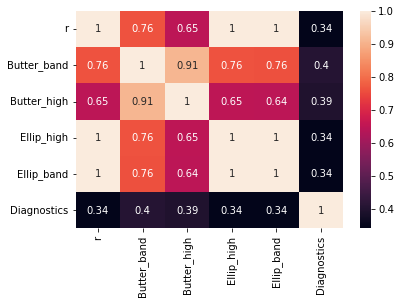

In [8]:
import seaborn as sn
import matplotlib.pyplot as plt

#Choose which r is going to be used
r = df_mat[['r','Butter_band','Butter_high', 'Ellip_high', 'Ellip_band', 'Diagnostics']]
corr_matrix = r.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [9]:
df_r = pd.DataFrame(columns=['Method','Corr', 'p-value']) #, index = ['r','Butter_high','Butter_band', 'Ellip_high', 'Ellip_band'])
r = df_mat[['r','Butter_band','Butter_high', 'Ellip_high', 'Ellip_band']] 
y = np.array(df_mat['Diagnostics'])

for column in r:
    x = np.array(df_mat[column])
    res, p_val = stats.pointbiserialr(y, x)
    df_r = df_r.append({'Method':column, 'Corr': res, 'p-value': p_val}, ignore_index=True)
    
df_r

,Method,Corr,p-value
0,r,0.339879,4.863701e-31
1,Butter_band,0.404900,1.720513e-44
2,Butter_high,0.394436,4.091001e-42
3,Ellip_high,0.340583,3.608360e-31
4,Ellip_band,0.340489,3.755333e-31


In [10]:
# Assim só deixamos o que tem maios corr com o diagnostic que é o butter high
# Assim só deixmaos o que tem maios corr com o diagnostic que é o butter high
r_max = df_mat[df_r['Method'].loc[df_r['Corr'].abs().idxmax()]]
print('The method with maximum value: ', r_max.name)
df_mat= df_mat.drop(columns = ['r','Butter_band','Butter_high', 'Ellip_high', 'Ellip_band'])
df_mat['r'] = r_max
#df_all = df_all.drop(df_all.index[72])
df_mat.columns


#df_all= df_mat
#df_all = df_all.drop(columns = ['r','r_band', 'rh_ellip', 'rb_ellip','record'])
#df_all = df_all.rename(columns={'r_high': 'r'})
#df_all = df_all.drop(df_all.index[72])
#df_all.head(75)

The method with maximum value:  Butter_band


Index(['voiceID', 'Diagnostics', 'Age', 'Gender_f', 'Gender_m', 'duration_s_',
       'meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs', 'Jitter', 'Shimmer', 'M1', 'M2',
       'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13',
       'M14', 'r'],
      dtype='object')

In [11]:
df_mat.to_csv(os.path.join("Dados","dados_svd_modelos.csv"), index=False)